---
title: 알고리즘 체인과 파이프라인
---

In [1]:
from preamble import *

## 데이터 전처리와 매개변수 선택

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0
)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다
scaler = MinMaxScaler().fit(X_train)

In [3]:
# 훈련 데이터의 스케일을 조정합니다
X_train_scaled = scaler.transform(X_train)
svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


In [4]:
from sklearn.model_selection import GridSearchCV

# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


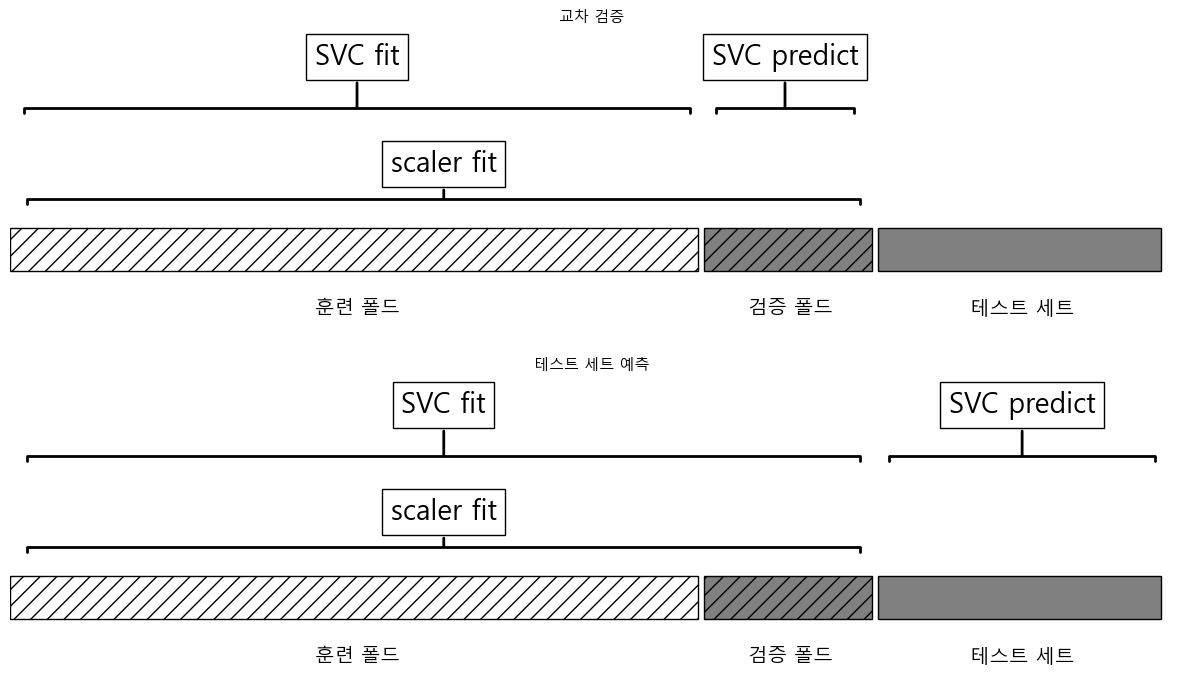

In [5]:
mglearn.plots.plot_improper_processing()

## 파이프라인 구축하기

In [6]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [7]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [8]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


## 그리드 서치에 파이프라인 적용하기

In [9]:
param_grid = {
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "svm__gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}

In [10]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수:", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


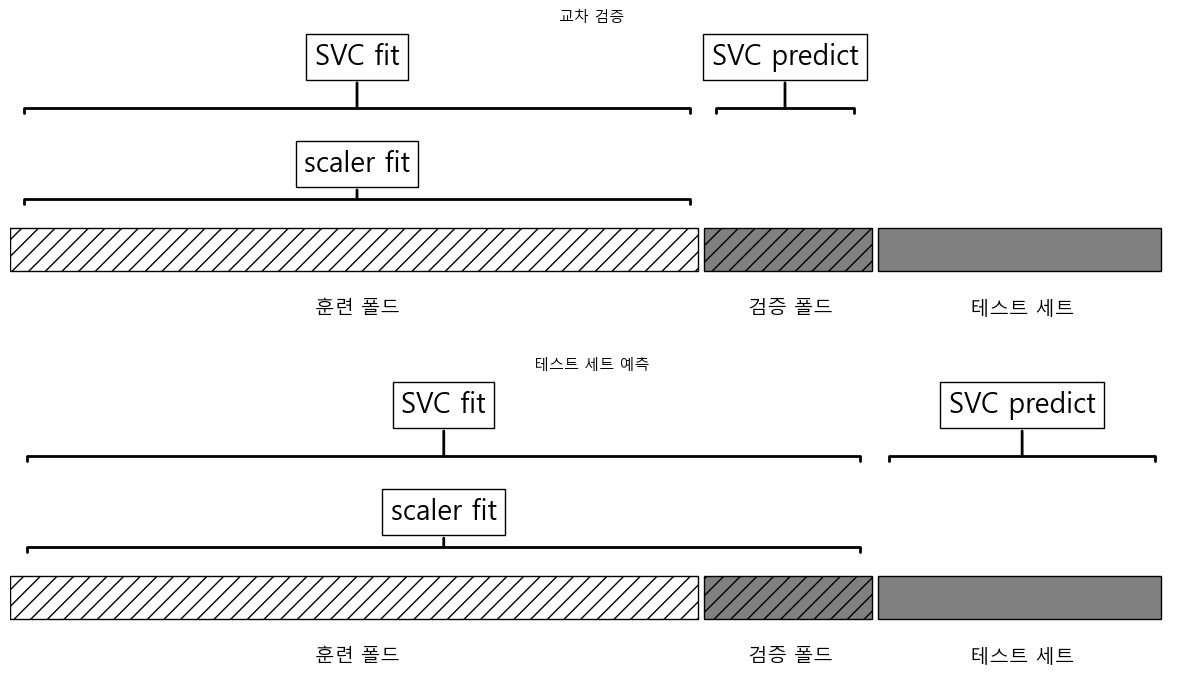

In [11]:
mglearn.plots.plot_proper_processing()

In [12]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [13]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape:", X_selected.shape)

X_selected.shape: (100, 500)


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print(
    "교차 검증 점수 (릿지): {:.2f}".format(
        np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))
    )
)

교차 검증 점수 (릿지): 0.91


In [15]:
pipe = Pipeline(
    [
        ("select", SelectPercentile(score_func=f_regression, percentile=5)),
        ("ridge", Ridge()),
    ]
)
print(
    "교차 검증 점수 (파이프라인): {:.2f}".format(
        np.mean(cross_val_score(pipe, X, y, cv=5))
    )
)

교차 검증 점수 (파이프라인): -0.25


## 파이프라인 인터페이스

In [16]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [17]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다
    return self.steps[-1][1].predict(X_transformed)

### 파이프라인 그리기

In [18]:
from sklearn import set_config

set_config(display="diagram")
pipe

Pipeline(steps=[('select',
                 SelectPercentile(percentile=5,
                                  score_func=<function f_regression at 0x0000013DF41B3740>)),
                ('ridge', Ridge())])

### `make_pipleline`을 사용한 파이프라인 생성

In [19]:
from sklearn.pipeline import make_pipeline

# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [20]:
print("파이프라인 단계:\n", pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n", pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


### 단계 속성에 접근하기

In [22]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps["pca"].components_
print("components.shape:", components.shape)

components.shape: (2, 30)


### 그리드 서치 안의 파이프라인의 속성에 접근하기

In [23]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [24]:
param_grid = {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4
)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [26]:
print("최상의 모델:\n", grid.best_estimator_)

최상의 모델:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [27]:
print("로지스틱 회귀 단계:\n", grid.best_estimator_.named_steps["logisticregression"])

로지스틱 회귀 단계:
 LogisticRegression(C=1, max_iter=1000)


In [28]:
print(
    "로지스틱 회귀 계수:\n",
    grid.best_estimator_.named_steps["logisticregression"].coef_,
)

로지스틱 회귀 계수:
 [[-0.448 -0.346 -0.417 -0.529 -0.158  0.603 -0.718 -0.784  0.048  0.275
  -1.295  0.053 -0.691 -0.919 -0.148  0.461 -0.126 -0.103  0.428  0.715
  -1.085 -1.093 -0.851 -1.041 -0.728  0.077 -0.836 -0.649 -0.649 -0.43 ]]


## 전처리와 모델의 매개변수를 위한 그리드 서치

In [29]:
# 보스턴 주택 데이터셋이 1.2 버전에서 삭제되므로 직접 다운로드합니다.
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\sigma\AppData\Local\Temp\ipykernel_2288\2788080595.py:3: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [30]:
param_grid = {
    "polynomialfeatures__degree": [1, 2, 3],
    "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100],
}

In [31]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

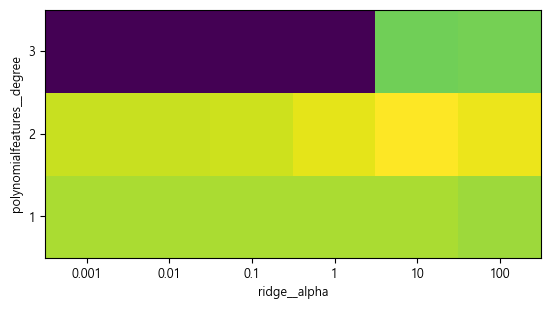

In [32]:
mglearn.tools.heatmap(
    grid.cv_results_["mean_test_score"].reshape(3, -1),
    xlabel="ridge__alpha",
    ylabel="polynomialfeatures__degree",
    xticklabels=param_grid["ridge__alpha"],
    yticklabels=param_grid["polynomialfeatures__degree"],
    vmin=0,
)
plt.show()  # 책에는 없음

In [33]:
print("최적의 매개변수:", grid.best_params_)

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [34]:
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

테스트 세트 점수: 0.77


In [35]:
param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


## 모델 선택을 위한 그리드 서치

In [36]:
pipe = Pipeline([("preprocessing", StandardScaler()), ("classifier", SVC())])

In [37]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {
        "classifier": [SVC()],
        "preprocessing": [StandardScaler()],
        "classifier__gamma": [0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    },
    {
        "classifier": [RandomForestClassifier(n_estimators=100)],
        "preprocessing": [None],
        "classifier__max_features": [1, 2, 3],
    },
]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0
)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


### 중복 계산 피하기

In [39]:
pipe = Pipeline(
    [("preprocessing", StandardScaler()), ("classifier", SVC())], memory="cache_folder"
)